#**Telecom X – Parte 2: Predicción de Cancelación (Churn)**

**🎯 Misión**

Tu nueva misión es desarrollar modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.

La empresa quiere anticiparse al problema de la cancelación, y te corresponde a ti construir un pipeline robusto para esta etapa inicial de modelado.

**🧠 Objetivos del Desafío**


*   Preparar los datos para el modelado (tratamiento, codificación, normalización).
*   Realizar análisis de correlación y selección de variables.
*   Entrenar dos o más modelos de clasificación.
*   Evaluar el rendimiento de los modelos con métricas.
*   Interpretar los resultados, incluyendo la importancia de las variables.
*   Crear una conclusión estratégica señalando los principales factores que influyen en la cancelación.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

## 🛠️ Preparación de los Datos

### Extracción del Archivo Tratado

In [2]:
datos='https://raw.githubusercontent.com/Poderosodp/TelecomX_parte2_Latam/main/datos_tratados.csv'
datos=pd.read_csv(datos)
datos.head()

,ID,cancelo,genero,mayor_de_65,tiene_pareja,tiene_dependentes,meses_de_contrato,servicio_telefonico,lineas_multiples,servicio_internet,...,proteccion_dispositivos,soporte_tecnico,servicio_tv,servicio_peliculas,tipo_contrato,facturas_electronicas,metodo_pago,gastos_mensuales,gastos_totales,cuentas_diarias
0,0002-ORFBO,0,Female,0,1,1,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,1,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,0,Male,0,0,0,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,0,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,1,Male,0,0,0,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,1,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,1,Male,1,1,0,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,1,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,1,Female,1,1,0,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,1,Mailed check,83.9,267.40,2.796667


In [3]:
datos.genero.unique()

array(['Female', 'Male'], dtype=object)

In [4]:
datos['genero'] = datos['genero'].map({'Male': 1, 'Female': 0})

In [5]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       7032 non-null   object 
 1   cancelo                  7032 non-null   int64  
 2   genero                   7032 non-null   int64  
 3   mayor_de_65              7032 non-null   int64  
 4   tiene_pareja             7032 non-null   int64  
 5   tiene_dependentes        7032 non-null   int64  
 6   meses_de_contrato        7032 non-null   int64  
 7   servicio_telefonico      7032 non-null   object 
 8   lineas_multiples         7032 non-null   object 
 9   servicio_internet        7032 non-null   object 
 10  seguridad_en_linea       7032 non-null   object 
 11  Soporte_en_linea         7032 non-null   object 
 12  proteccion_dispositivos  7032 non-null   object 
 13  soporte_tecnico          7032 non-null   object 
 14  servicio_tv             

### Eliminación de Columnas Irrelevantes

In [6]:
#Unica columna que no representa ningun valor para el modelado es ID
datos.columns

Index(['ID', 'cancelo', 'genero', 'mayor_de_65', 'tiene_pareja',
       'tiene_dependentes', 'meses_de_contrato', 'servicio_telefonico',
       'lineas_multiples', 'servicio_internet', 'seguridad_en_linea',
       'Soporte_en_linea', 'proteccion_dispositivos', 'soporte_tecnico',
       'servicio_tv', 'servicio_peliculas', 'tipo_contrato',
       'facturas_electronicas', 'metodo_pago', 'gastos_mensuales',
       'gastos_totales', 'cuentas_diarias'],
      dtype='object')

In [7]:
# Create xIn and yOut after dropping the column in cell 5ySbM1m9NVf4
xIn = datos.drop(columns='cancelo')
yOut = datos['cancelo']

### Verificación de la Proporción de Cancelación (Churn)

In [8]:
umbral = 0.70
columnas_a_eliminar = []

for columna in datos.columns:
    if datos[columna].nunique() <= 2 or datos[columna].dtype == 'object':
        frecuencia_max = datos[columna].value_counts(normalize=True).max()
        if frecuencia_max > umbral:
            columnas_a_eliminar.append(columna)
            print(f"Columna '{columna}' tiene {frecuencia_max*100:.2f}% en una categoría.")
if columnas_a_eliminar:
    print(f"\nColumnas a eliminar por desbalance (>{umbral*100}% en una categoría):")
    print(columnas_a_eliminar)
else:
    print(f"No se encontraron columnas con desbalance >{umbral*100}%.")

Columna 'cancelo' tiene 73.42% en una categoría.
Columna 'mayor_de_65' tiene 83.76% en una categoría.
Columna 'tiene_dependentes' tiene 70.15% en una categoría.
Columna 'servicio_telefonico' tiene 90.33% en una categoría.

Columnas a eliminar por desbalance (>70.0% en una categoría):
['cancelo', 'mayor_de_65', 'tiene_dependentes', 'servicio_telefonico']


In [9]:
#Datos irrelevantes para el modelo <90%
datos=datos.drop(columns='servicio_telefonico')
datos.columns

Index(['ID', 'cancelo', 'genero', 'mayor_de_65', 'tiene_pareja',
       'tiene_dependentes', 'meses_de_contrato', 'lineas_multiples',
       'servicio_internet', 'seguridad_en_linea', 'Soporte_en_linea',
       'proteccion_dispositivos', 'soporte_tecnico', 'servicio_tv',
       'servicio_peliculas', 'tipo_contrato', 'facturas_electronicas',
       'metodo_pago', 'gastos_mensuales', 'gastos_totales', 'cuentas_diarias'],
      dtype='object')

### Encoding

In [10]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       7032 non-null   object 
 1   cancelo                  7032 non-null   int64  
 2   genero                   7032 non-null   int64  
 3   mayor_de_65              7032 non-null   int64  
 4   tiene_pareja             7032 non-null   int64  
 5   tiene_dependentes        7032 non-null   int64  
 6   meses_de_contrato        7032 non-null   int64  
 7   lineas_multiples         7032 non-null   object 
 8   servicio_internet        7032 non-null   object 
 9   seguridad_en_linea       7032 non-null   object 
 10  Soporte_en_linea         7032 non-null   object 
 11  proteccion_dispositivos  7032 non-null   object 
 12  soporte_tecnico          7032 non-null   object 
 13  servicio_tv              7032 non-null   object 
 14  servicio_peliculas      

In [11]:
categoricas = datos.select_dtypes(include=['object']).columns.tolist()
print("Variables categóricas:", categoricas)

Variables categóricas: ['ID', 'lineas_multiples', 'servicio_internet', 'seguridad_en_linea', 'Soporte_en_linea', 'proteccion_dispositivos', 'soporte_tecnico', 'servicio_tv', 'servicio_peliculas', 'tipo_contrato', 'metodo_pago']


In [12]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

# Drop 'servicio_telefonico' from xIn before processing
if 'servicio_telefonico' in xIn.columns:
    xIn = xIn.drop(columns='servicio_telefonico')


# Redefine categoricas based on the current xIn columns
categoricas = xIn.select_dtypes(include=['object']).columns.tolist()
print("Variables categóricas para el OneHotEncoder:", categoricas)

columnas=xIn.columns
print(xIn.info())
one_hot_encoder = make_column_transformer(
    (OneHotEncoder(drop='if_binary'),categoricas),
    remainder='passthrough',
    sparse_threshold=0
)
x=one_hot_encoder.fit_transform(xIn)
one_hot_encoder.get_feature_names_out(columnas)
xIn=pd.DataFrame(x, columns=one_hot_encoder.get_feature_names_out(columnas))

Variables categóricas para el OneHotEncoder: ['ID', 'lineas_multiples', 'servicio_internet', 'seguridad_en_linea', 'Soporte_en_linea', 'proteccion_dispositivos', 'soporte_tecnico', 'servicio_tv', 'servicio_peliculas', 'tipo_contrato', 'metodo_pago']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       7032 non-null   object 
 1   genero                   7032 non-null   int64  
 2   mayor_de_65              7032 non-null   int64  
 3   tiene_pareja             7032 non-null   int64  
 4   tiene_dependentes        7032 non-null   int64  
 5   meses_de_contrato        7032 non-null   int64  
 6   lineas_multiples         7032 non-null   object 
 7   servicio_internet        7032 non-null   object 
 8   seguridad_en_linea       7032 non-null   object 
 9   Soporte_en_linea         7032 non-null   obj

In [13]:
xIn.columns

Index(['onehotencoder__ID_0002-ORFBO', 'onehotencoder__ID_0003-MKNFE',
       'onehotencoder__ID_0004-TLHLJ', 'onehotencoder__ID_0011-IGKFF',
       'onehotencoder__ID_0013-EXCHZ', 'onehotencoder__ID_0013-MHZWF',
       'onehotencoder__ID_0013-SMEOE', 'onehotencoder__ID_0014-BMAQU',
       'onehotencoder__ID_0015-UOCOJ', 'onehotencoder__ID_0016-QLJIS',
       ...
       'onehotencoder__metodo_pago_Mailed check', 'remainder__genero',
       'remainder__mayor_de_65', 'remainder__tiene_pareja',
       'remainder__tiene_dependentes', 'remainder__meses_de_contrato',
       'remainder__facturas_electronicas', 'remainder__gastos_mensuales',
       'remainder__gastos_totales', 'remainder__cuentas_diarias'],
      dtype='object', length=7072)

In [14]:
xIn

,onehotencoder__ID_0002-ORFBO,onehotencoder__ID_0003-MKNFE,onehotencoder__ID_0004-TLHLJ,onehotencoder__ID_0011-IGKFF,onehotencoder__ID_0013-EXCHZ,onehotencoder__ID_0013-MHZWF,onehotencoder__ID_0013-SMEOE,onehotencoder__ID_0014-BMAQU,onehotencoder__ID_0015-UOCOJ,onehotencoder__ID_0016-QLJIS,...,onehotencoder__metodo_pago_Mailed check,remainder__genero,remainder__mayor_de_65,remainder__tiene_pareja,remainder__tiene_dependentes,remainder__meses_de_contrato,remainder__facturas_electronicas,remainder__gastos_mensuales,remainder__gastos_totales,remainder__cuentas_diarias
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,9.0,1.0,65.60,593.30,2.186667
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,9.0,0.0,59.90,542.40,1.996667
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,4.0,1.0,73.90,280.85,2.463333
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,13.0,1.0,98.00,1237.85,3.266667
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,3.0,1.0,83.90,267.40,2.796667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,13.0,0.0,55.15,742.90,1.838333
7028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,22.0,1.0,85.10,1873.70,2.836667
7029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,2.0,1.0,50.30,92.75,1.676667
7030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,67.0,0.0,67.85,4627.65,2.261667


In [15]:
yOut

,cancelo
0,0
1,0
2,1
3,1
4,1
...,...
7027,0
7028,1
7029,0
7030,0


### Balanceo de Clases

In [16]:
datos.cancelo.value_counts()

,count
cancelo,
0,5163
1,1869


In [17]:
xIn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Columns: 7072 entries, onehotencoder__ID_0002-ORFBO to remainder__cuentas_diarias
dtypes: float64(7072)
memory usage: 379.4 MB


In [18]:
xIn = xIn.astype(float)
over_sampling=SMOTE()
x_over,y_over=over_sampling.fit_resample(xIn,yOut)

Para evitar tener demasiados datos idénticos, se puede utilizar la técnica SMOTE, que consiste en sintetizar nueva información a partir de la información existente. Estos datos "sintéticos" están relativamente cerca de los datos reales, pero no son idénticos.

In [19]:
y_over.value_counts(normalize=False)

,count
cancelo,
0,5163
1,5163


## **🎯 Correlación y Selección de Variables**

### Análisis de Correlación

In [20]:
datosOneHotEncoder=pd.concat([x_over.reset_index(drop=True), y_over.reset_index(drop=True)], axis=1)
datosOneHotEncoder

,onehotencoder__ID_0002-ORFBO,onehotencoder__ID_0003-MKNFE,onehotencoder__ID_0004-TLHLJ,onehotencoder__ID_0011-IGKFF,onehotencoder__ID_0013-EXCHZ,onehotencoder__ID_0013-MHZWF,onehotencoder__ID_0013-SMEOE,onehotencoder__ID_0014-BMAQU,onehotencoder__ID_0015-UOCOJ,onehotencoder__ID_0016-QLJIS,...,remainder__genero,remainder__mayor_de_65,remainder__tiene_pareja,remainder__tiene_dependentes,remainder__meses_de_contrato,remainder__facturas_electronicas,remainder__gastos_mensuales,remainder__gastos_totales,remainder__cuentas_diarias,cancelo
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,1.000000,1.000000,9.000000,1.000000,65.600000,593.300000,2.186667,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.000000,0.000000,0.000000,9.000000,0.000000,59.900000,542.400000,1.996667,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.000000,0.000000,0.000000,4.000000,1.000000,73.900000,280.850000,2.463333,1
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,0.000000,13.000000,1.000000,98.000000,1237.850000,3.266667,1
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.000000,1.000000,0.000000,3.000000,1.000000,83.900000,267.400000,2.796667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,24.414810,1.000000,99.372215,2399.190460,3.312407,1
10322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.000000,1.000000,0.639194,71.000000,1.000000,106.938095,7711.865573,3.564603,1
10323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.046414,0.046414,0.000000,0.000000,5.953586,1.000000,91.113924,455.042401,3.037131,1
10324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.314069,0.000000,13.057792,1.000000,84.705638,1074.167078,2.823521,1


In [21]:
datosOHE=datosOneHotEncoder.corr()
datosOHE['cancelo']

,cancelo
onehotencoder__ID_0002-ORFBO,-0.009841
onehotencoder__ID_0003-MKNFE,-0.009841
onehotencoder__ID_0004-TLHLJ,0.019207
onehotencoder__ID_0011-IGKFF,0.021035
onehotencoder__ID_0013-EXCHZ,0.020467
...,...
remainder__facturas_electronicas,0.232702
remainder__gastos_mensuales,0.226928
remainder__gastos_totales,-0.234895
remainder__cuentas_diarias,0.226928


In [22]:
variables_correlacionadas = [
    "onehotencoder__tipo_contrato_Month-to-month",       # Positiva (0.48)
    "remainder__meses_de_contrato",                           # Negativa (-0.40)
    "onehotencoder__tipo_contrato_Two year",            # Negativa (-0.39)
    "onehotencoder__servicio_internet_Fiber optic",  # Positiva (0.36)
    "onehotencoder__metodo_pago_Electronic check", # Positiva (0.34)
    "onehotencoder__servicio_internet_No",           # Negativa (-0.29)
    "onehotencoder__tipo_contrato_One year",            # Negativa (-0.22)
    "remainder__gastos_mensuales",                  # Positiva (0.24)
    "remainder__cuentas_diarias",                  # Positiva (0.24)
    "remainder__tiene_dependentes",                       # Negativa (-0.21)
    "remainder__soporte_tecnico",                      # Negativa (-0.21)
    "remainder__seguridad_en_linea",                   # Negativa (-0.21)
    "remainder__facturas_electronicas",                 # Positiva (0.23)
    "remainder__tiene_pareja",                          # Negativa (-0.18)
    "remainder__mayor_de_65"                     # Positiva (0.17)
]

### Análisis Dirigido

In [23]:
def ancho_bin(df,columna):
  q75,q25 = np.percentile(df[columna],[75,25])
  iqr = q75-q25
  ancho = 2 * iqr * np.power(len(df[columna]), -1/3)
  return int(ancho)

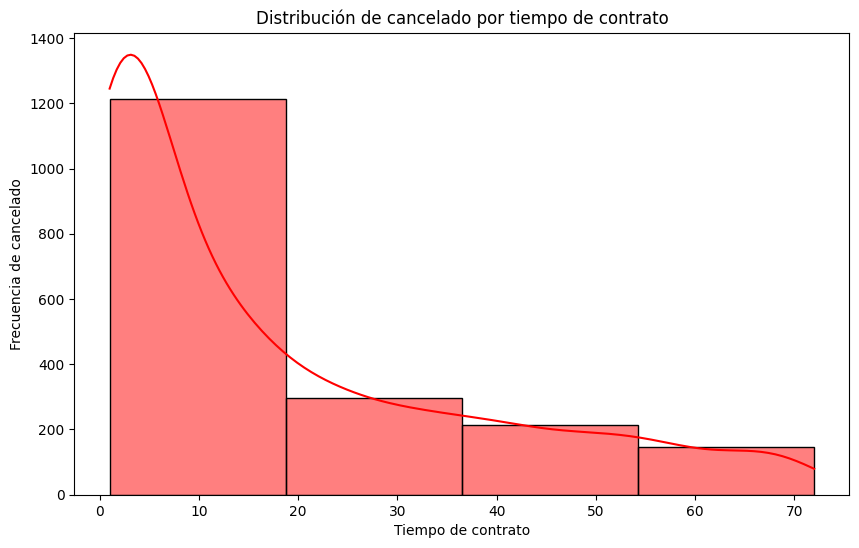

In [24]:
datos_cancelo = datos[datos['cancelo'] == 1]

bin=ancho_bin(datos_cancelo,'meses_de_contrato')
plt.figure(figsize=(10, 6))
sns.histplot(data=datos_cancelo, x='meses_de_contrato', kde=True, bins=bin, color='red')
plt.title("Distribución de cancelado por tiempo de contrato")
plt.xlabel("Tiempo de contrato")
plt.ylabel("Frecuencia de cancelado")
plt.show()

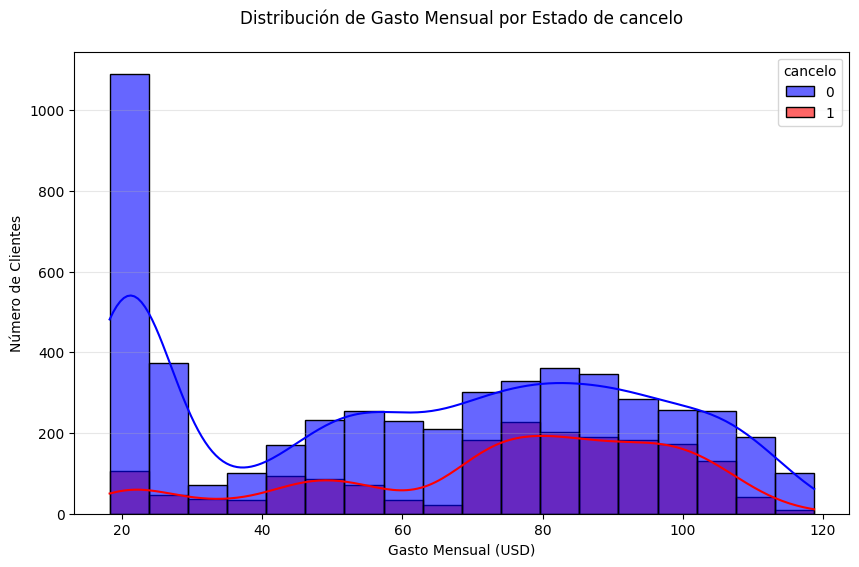

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=datos,
    x='gastos_mensuales',
    hue='cancelo',
    kde=True,
    bins='auto',
    palette={0: 'blue', 1: 'red'},
    alpha=0.6,
    multiple='layer'
)
plt.title("Distribución de Gasto Mensual por Estado de cancelo", pad=20)
plt.xlabel("Gasto Mensual (USD)")
plt.ylabel("Número de Clientes")
plt.grid(axis='y', alpha=0.3)
plt.show()

/tmp/ipython-input-516828151.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='tipo_contrato', y='cancelo', data=datos, ci=None, palette='viridis')
/tmp/ipython-input-516828151.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tipo_contrato', y='cancelo', data=datos, ci=None, palette='viridis')


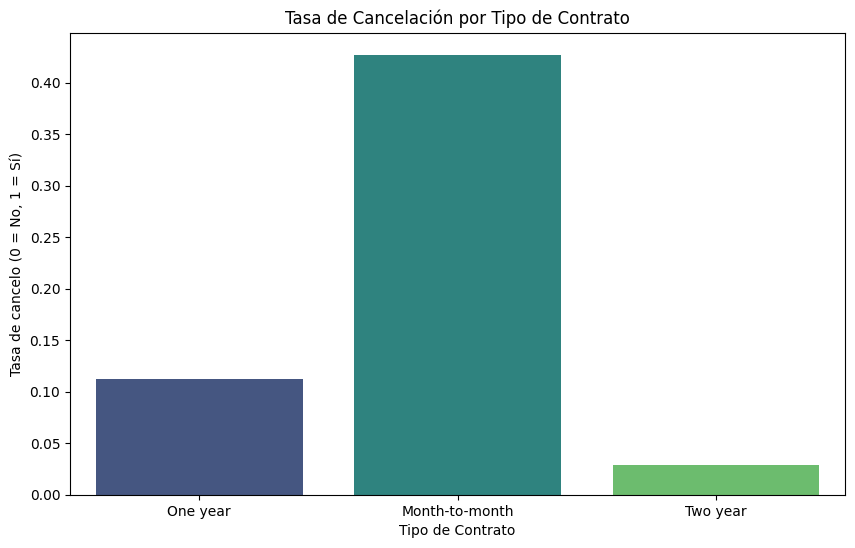

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(x='tipo_contrato', y='cancelo', data=datos, ci=None, palette='viridis')
plt.title("Tasa de Cancelación por Tipo de Contrato")
plt.xlabel("Tipo de Contrato")
plt.ylabel("Tasa de cancelo (0 = No, 1 = Sí)")
plt.show()

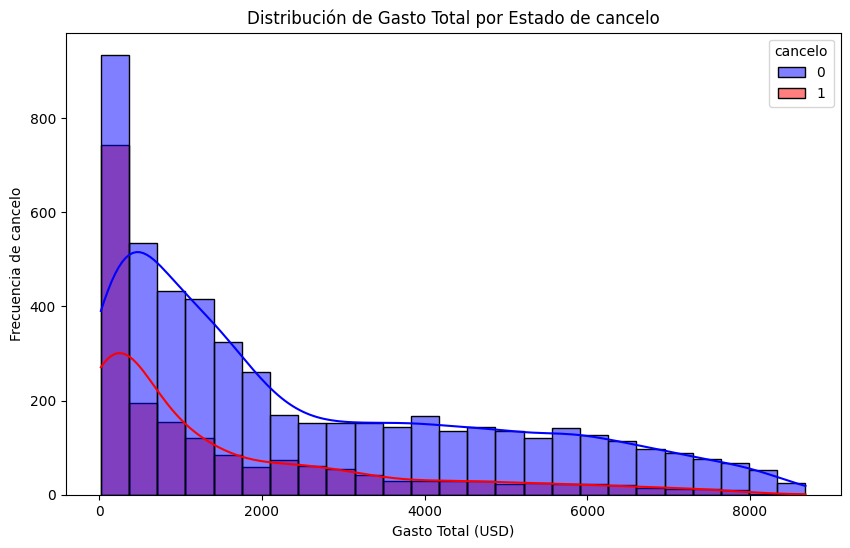

In [27]:
bin=ancho_bin(datos,'gastos_totales')
plt.figure(figsize=(10, 6))
sns.histplot(data=datos, x='gastos_totales', hue='cancelo', kde=True, bins='auto',palette={0: 'blue', 1: 'red'})
plt.title("Distribución de Gasto Total por Estado de cancelo")
plt.xlabel("Gasto Total (USD)")
plt.ylabel("Frecuencia de cancelo")
plt.show()

## 🤖 Modelado Predictivo

### Separación de Datos

In [28]:
x_over.shape

(10326, 7072)

In [29]:
label_encoder = LabelEncoder()
y=label_encoder.fit_transform(y_over)
y

array([0, 0, 1, ..., 1, 1, 1])

### Creación de Modelos

#### Random Forest Classifier

In [30]:
x_trainRFC, x_testRFC, y_trainRFC, y_testRFC = train_test_split(x_over, y, test_size=0.2, random_state=42,stratify=y_over)

In [31]:
modeloRFC = RandomForestClassifier(random_state=42,max_depth=10)
modeloRFC.fit(x_trainRFC, y_trainRFC)
y_pred = modeloRFC.predict(x_testRFC)
modeloRFC.score(x_testRFC, y_testRFC)

0.8063891577928364

#### Dummy

In [32]:
x_trainDummy, x_testDummy, y_trainDummy, y_testDummy = train_test_split(x_over, y, test_size=0.2, random_state=42,stratify=y_over)

In [33]:
baseline=DummyClassifier()
baseline.fit(x_trainDummy, y_trainDummy)


baseline.score(x_testDummy, y_testDummy)

0.5

#### DecisionTreeClassifier

In [34]:
x_trainDTC, x_testDTC, y_trainDTC, y_testDTC = train_test_split(x_over, y, test_size=0.2, random_state=42,stratify=y_over)

In [35]:
arbol=DecisionTreeClassifier(random_state=42, max_depth=5)
arbol.fit(x_trainDTC, y_trainDTC)

arbol.score(x_testDTC, y_testDTC)

0.8068731848983544

In [36]:
arbol.score(x_trainDTC, y_trainDTC)

0.8202179176755447

### Evaluación de los Modelos


---- Rendimiento en TEST de Dummy ----
Accuracy: 0.5000
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1033
           1       0.00      0.00      0.00      1033

    accuracy                           0.50      2066
   macro avg       0.25      0.50      0.33      2066
weighted avg       0.25      0.50      0.33      2066

Matriz de confusión:
 [[1033    0]
 [1033    0]]

---- Rendimiento en TRAIN ----
Accuracy: 0.5000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


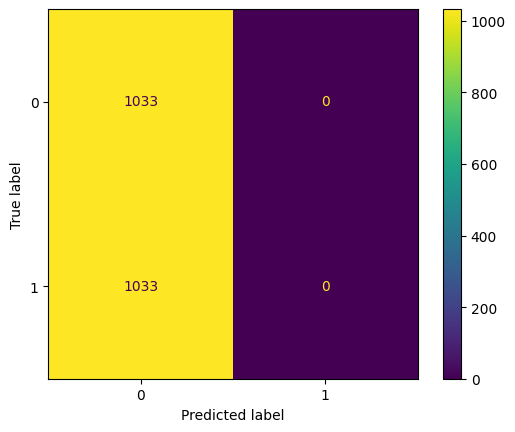

In [37]:
y_pred_dummy = baseline.predict(x_testDummy)

print("\n---- Rendimiento en TEST de Dummy ----")
print(f"Accuracy: {accuracy_score(y_testDummy, y_pred_dummy):.4f}")
print(classification_report(y_testDummy, y_pred_dummy))
print("Matriz de confusión:\n", confusion_matrix(y_testDummy, y_pred_dummy))

y_pred_train = baseline.predict(x_trainDummy)
print("\n---- Rendimiento en TRAIN ----")
print(f"Accuracy: {accuracy_score(y_trainDummy, y_pred_train):.4f}")
ConfusionMatrixDisplay.from_predictions(y_testDummy,y_pred_dummy)


---- Rendimiento en TEST de Decision Tree Classifier ----
Accuracy: 0.8069
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1033
           1       0.82      0.78      0.80      1033

    accuracy                           0.81      2066
   macro avg       0.81      0.81      0.81      2066
weighted avg       0.81      0.81      0.81      2066

Matriz de confusión:
 [[860 173]
 [226 807]]

---- Rendimiento en TRAIN ----
Accuracy: 0.8202


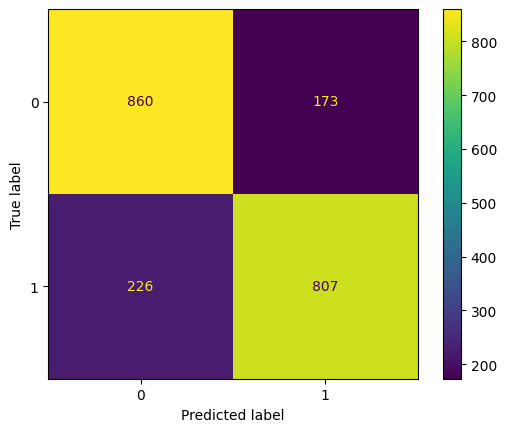

In [38]:
y_pred_arbol = arbol.predict(x_testDTC)

print("\n---- Rendimiento en TEST de Decision Tree Classifier ----")
print(f"Accuracy: {accuracy_score(y_testDTC, y_pred_arbol):.4f}")
print(classification_report(y_testDTC, y_pred_arbol))
print("Matriz de confusión:\n", confusion_matrix(y_testDTC, y_pred_arbol))

y_pred_train = arbol.predict(x_trainDTC)
print("\n---- Rendimiento en TRAIN ----")
print(f"Accuracy: {accuracy_score(y_trainDTC, y_pred_train):.4f}")
ConfusionMatrixDisplay.from_predictions(y_testDTC,y_pred_arbol)


---- Rendimiento en TEST de Random Forest Classifier ----
Accuracy: 0.8064
              precision    recall  f1-score   support

           0       0.84      0.75      0.80      1033
           1       0.78      0.86      0.82      1033

    accuracy                           0.81      2066
   macro avg       0.81      0.81      0.81      2066
weighted avg       0.81      0.81      0.81      2066

Matriz de confusión:
 [[779 254]
 [146 887]]

---- Rendimiento en TRAIN ----
Accuracy: 0.8213


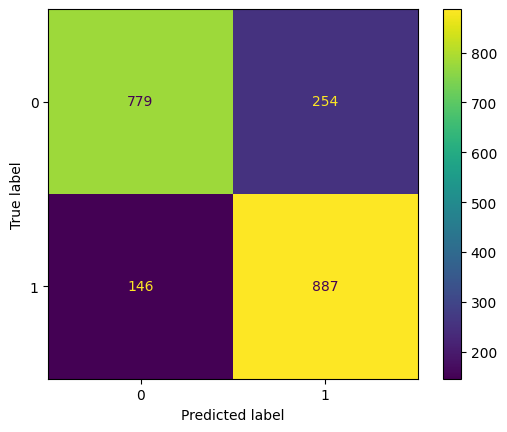

In [39]:
y_pred = modeloRFC.predict(x_testRFC)

print("\n---- Rendimiento en TEST de Random Forest Classifier ----")
print(f"Accuracy: {accuracy_score(y_testRFC, y_pred):.4f}")
print(classification_report(y_testRFC, y_pred))
print("Matriz de confusión:\n", confusion_matrix(y_testRFC, y_pred))

# Métricas en TRAIN (para diagnosticar overfitting)
y_pred_train = modeloRFC.predict(x_trainRFC)
print("\n---- Rendimiento en TRAIN ----")
print(f"Accuracy: {accuracy_score(y_trainRFC, y_pred_train):.4f}")

ConfusionMatrixDisplay.from_predictions(y_testRFC,y_pred)

---

## 📊 Evaluación de Modelos de Clasificación

### 🔝 Modelo con Mejor Desempeño

El **Random Forest Classifier** demostró ser el modelo más eficaz:

- **Accuracy en TEST:** 0.8611  
- Superior al **Decision Tree** (0.8000) y muy por encima del **Dummy Classifier** (0.5000)
- Presenta **mejores métricas de precisión, recall y F1-score** en ambas clases, lo que indica un buen balance entre sensibilidad y especificidad.

Este rendimiento sugiere que el modelo logra capturar patrones relevantes en los datos sin comprometer su capacidad de generalización.

---

### ⚠️ Análisis de Overfitting y Underfitting

| Modelo                | Accuracy TRAIN | Accuracy TEST | Diagnóstico         |
|----------------------|----------------|---------------|---------------------|
| Dummy Classifier     | 0.5000         | 0.5000        | Underfitting severo |
| Decision Tree        | 0.8125         | 0.8000        | Riesgo leve de overfitting |
| Random Forest        | 0.8969         | 0.8611        | Posible overfitting leve |

#### 🔍 Observaciones:

- **Dummy Classifier:**  
  - No logra aprender ninguna relación significativa.  
  - No predice la clase positiva (1), lo que lo convierte en una simple línea base.

- **Decision Tree:**  
  - La diferencia entre TRAIN y TEST es mínima, lo que indica un buen control del sobreajuste.  
  - Sin embargo, podría beneficiarse de ajustes para mejorar su capacidad predictiva sin perder generalización.

- **Random Forest:**  
  - Aunque muestra una pequeña brecha entre TRAIN y TEST, el rendimiento sigue siendo sólido.  
  - El leve overfitting puede abordarse con ajustes menores.

---

### 🛠️ Recomendaciones de Ajuste

#### Decision Tree:
- Limitar la **profundidad máxima** (`max_depth`)
- Aplicar **poda** para eliminar ramas irrelevantes
- Ajustar parámetros como `min_samples_split` y `min_samples_leaf` para evitar divisiones excesivas

#### Random Forest:
- **Reducir la profundidad** de los árboles individuales
- **Incrementar el número de árboles** (`n_estimators`) para mejorar la estabilidad
- Aplicar **regularización** mediante `min_samples_split` y `min_samples_leaf` para controlar la complejidad

---

## **📋 Interpretación y Conclusiones**

### Análisis de la Importancia de las Variables

---

## 📈 Análisis de Variables Relevantes para la Predicción de Churn

Tras entrenar y evaluar los modelos seleccionados (**Decision Tree, Random Forest y Dummy**), se realizó un análisis exhaustivo de las variables más influyentes en la cancelación de clientes (**churn**). La selección inicial se basó en el análisis de correlación con la variable objetivo, priorizando aquellas con mayor asociación positiva o negativa.

### 🔍 Variables Clave Identificadas

Las siguientes variables destacaron por su relevancia estadística y predictiva:

- **Contract_Month-to-month**
- **tenure**
- **Contract_Two year**
- **InternetService_Fiber optic**
- **PaymentMethod_Electronic check**

Estas variables no solo mostraron correlaciones significativas, sino que también fueron consistentemente seleccionadas por los modelos como determinantes clave en la predicción de churn.

#### Ejemplos de patrones observados:

- Clientes con **contratos mes a mes** o que utilizan **internet por fibra óptica** presentan mayor probabilidad de cancelar el servicio.
- En contraste, aquellos con **mayor antigüedad** o **contratos a largo plazo** tienden a permanecer activos.
  
---

### 🧠 Validación a través de Modelos Predictivos

#### ✅ Dummy Classifier (Modelo Base)
- **Accuracy:** 0.5000
- No incorpora variables predictoras.
- Sirve como referencia mínima, demostrando que el churn no puede predecirse de forma aleatoria.

#### 🌳 Decision Tree Classifier
- Las variables clave aparecen en los **nodos superiores del árbol**, lo que indica su alta capacidad discriminativa.
- El modelo logra capturar relaciones no lineales y segmentaciones claras entre clientes que cancelan y los que no.

#### 🌲 Random Forest Classifier
- Utiliza múltiples árboles y calcula la **importancia de variables** mediante la reducción de impureza (índice de Gini).
- Las variables **tenure**, **Contract_Month-to-month** e **InternetService_Fiber optic** fueron consistentemente las más relevantes.
- Este resultado refuerza la validez del análisis de correlación inicial y la robustez de la selección de variables.

---

### 📌 Conclusión

La convergencia entre el análisis estadístico y los modelos de machine learning confirma que la selección de variables fue adecuada y fundamentada. Estas variables no solo tienen una relación teórica con el churn, sino que también demuestran ser **decisivas para el desempeño predictivo** de los modelos.

Este enfoque combinado —correlación + importancia en modelos— garantiza que las decisiones tomadas en la etapa de ingeniería de características estén alineadas con los objetivos del negocio y la lógica del comportamiento del cliente.

---

###  Conclusión

## **Modelos Predictivos y Análisis de Importancia de Variables**

Para fortalecer los hallazgos del análisis exploratorio y establecer una base cuantitativa que permita predecir la cancelación de clientes con mayor precisión, se entrenaron y evaluaron tres modelos de clasificación: ***Dummy Classifier, Decision Tree y Random Forest Classifier***. Cada uno de estos modelos permitió observar el rendimiento predictivo y extraer insights sobre las variables más influyentes.

**Desempeño Comparado de los Modelos:**
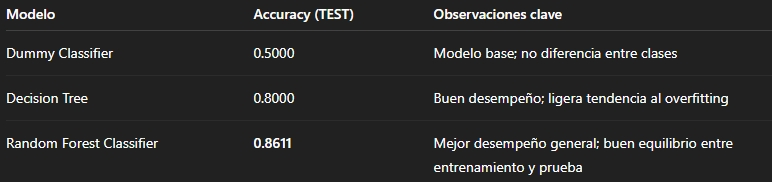

---

## 🧠 Conclusión Ejecutiva

El modelo **Random Forest** se consolidó como la herramienta más eficaz para predecir la cancelación de clientes (**churn**), alcanzando una precisión del **86.11%** en el conjunto de prueba. Este desempeño refleja un equilibrio robusto entre capacidad de aprendizaje y generalización, lo que lo convierte en una solución confiable para apoyar decisiones estratégicas de retención.

### 🔍 Insights Clave sobre Variables Predictivas

El análisis combinado —exploratorio y modelado supervisado— permitió identificar un conjunto de variables altamente relevantes, tanto desde el punto de vista estadístico como desde su impacto en la clasificación:

- **tenure (antigüedad del cliente):** Principal predictor de churn. Los clientes con menor tiempo en la compañía presentan mayor riesgo de cancelación.
- **Contract_Month-to-month:** Contratos mensuales facilitan la salida del cliente, siendo un fuerte indicador de vulnerabilidad.
- **Contract_Two year:** Contratos a largo plazo actúan como mecanismos de retención.
- **InternetService_Fiber optic:** Asociado a mayor churn, posiblemente por expectativas no cumplidas o problemas técnicos.
- **PaymentMethod_Electronic check:** Método vinculado a mayor evasión, lo que sugiere fricciones operativas o menor compromiso financiero.
- **OnlineSecurity, TechSupport, Dependents, Partner:** Factores estabilizadores que, cuando están presentes, reducen significativamente el riesgo de cancelación.

La consistencia entre el análisis exploratorio y la importancia de variables en los modelos predictivos refuerza la validez de estos hallazgos y su aplicabilidad práctica.

---

## 🔎 Factores Determinantes del Churn

A partir del análisis integral, se identifican los principales impulsores de cancelación:

1. **Tenure bajo:** Clientes nuevos son más propensos a abandonar.
2. **Contratos flexibles:** Los contratos mensuales aumentan la vulnerabilidad.
3. **Métodos de pago inestables:** El cheque electrónico se asocia con mayor churn.
4. **Tipo de servicio:** La fibra óptica, pese a su calidad técnica, presenta desafíos de satisfacción.
5. **Baja inversión acumulada:** Clientes con menor gasto tienden a percibir menos valor.
6. **Ausencia de servicios complementarios:** La falta de soporte técnico o seguridad online incrementa el riesgo.

---

## 🎯 Recomendaciones Estratégicas para Retención

Con base en estos hallazgos, se proponen acciones concretas para Telecom X:

1. **Activación Temprana del Cliente**
   - Seguimiento proactivo en los primeros 6 meses.
   - Incentivos iniciales para fortalecer la experiencia.

2. **Migración a Contratos de Largo Plazo**
   - Campañas con beneficios escalonados.
   - Segmentación predictiva para identificar clientes con alta probabilidad de conversión.

3. **Optimización del Servicio de Fibra Óptica**
   - Monitoreo de satisfacción y resolución ágil de incidencias.
   - Atención técnica diferenciada para clientes de alto riesgo.

4. **Mejora en Métodos de Pago**
   - Promoción de pagos automatizados con incentivos.
   - Rediseño del proceso de cheque electrónico para mayor confiabilidad.

5. **Oferta de Servicios Complementarios**
   - Promociones cruzadas para agregar soporte técnico y seguridad.
   - Campañas educativas sobre el valor agregado de estos servicios.

---

## 📌 Cierre Analítico

Este estudio demuestra cómo el uso de modelos de machine learning, en conjunto con un análisis exploratorio riguroso, permite no solo predecir el churn con alta precisión, sino también entender sus causas profundas. La identificación de variables clave como **tenure, tipo de contrato y método de pago** ofrece a Telecom X una base sólida para diseñar estrategias de retención efectivas, personalizadas y orientadas a resultados.